In [8]:
from llm.LLMModel import *
from llm.LlamaLoader import LlamaLoader, LlamaCpp
from ner.llm_ner.prompt_techniques.pt_multi_pt import PT_Multi_PT, PT_2Time_Tagger
from ner.llm_ner.prompt_techniques.pt_discussion import PT_OutputList
from ner.llm_ner.few_shots_techniques import *
%reload_ext autoreload
%autoreload 2
from ner.evaluating_confidence import *

In [ ]:
data_train = load_conll_dataset(split = 'train', cleaned = True)
data_test =  load_conll_dataset(split = 'test',  cleaned = True)

In [ ]:
model = MistralAI(llm_loader = Llama_LlamaCpp())
fst = FST_Sentence(data_train, 3)
multi_pt = PT_2Time_Tagger(fst)

In [ ]:
sentence = data_test[18]
logits_for_tags, output, index, values = get_logits_for_tags(sentence, model, pt = multi_pt)
logits_for_tags

In [ ]:
generated_tokens = list(model.model.model.eval_tokens)[-output['usage']['completion_tokens']:]
generated_logits = list(model.model.model.eval_logits)[-output['usage']['completion_tokens']:]


In [ ]:
[logits[28753] for logits in generated_logits ]

In [ ]:
logits_for_tags = [{'gold_tag' : gold_tag, 'tags_logits': {tag: generated_logits[idx][mapping_letter_tokens[tag][1]] for tag in mapping_letter_tokens.keys()}} for idx, gold_tag in zip(index,values)]
logits_for_tags

In [ ]:
# Afficher n = 0 et n = 2 où LOC est attendu mais on donne du ORG
n = 2
sentence = data_test[n]['text']
print(data_test[n]['text'])
print(data_test[n]['spans'])
get_logits_for_tags(sentence, model, pt)

In [ ]:
sentence = "Washington is the president of the United States"
sentence_o = " [['Washington', 'LOC'], ['United States', 'LOC']] "
prompt = llama_ner.get_prompts(sentence=sentence, tags = [], n = 0)

output = llm(prompt, stop = ["<end_output>"])

In [ ]:
from ner.evaluating_confidence import get_logits_for_tags
sentences = [
    "Washington is the president of the United States",
    "John is an important person living in Paris"
]
for sent in sentences :
    print(get_logits_for_tags(sent, llm, llama_ner))

In [ ]:
model.model.detokenize([464, 28753, 647])

In [ ]:
# print(model.model.tokenize("'World Cup': 'P'".encode()))'World Cup': 'P'
# print(model.model.tokenize("'World Cup': 'P'".encode()))

print(model.model.tokenize("'World Cup': 'P', ".encode()))
print(model.model.tokenize("': 'M', ".encode()))
print(model.model.tokenize(": 'L', ".encode()))
print(model.model.tokenize(": 'O', ".encode()))
print(model.model.tokenize(": 'N', ".encode()))

In [ ]:
list(model.model.eval_tokens)

In [ ]:
model.model.model.detokenize(list(model.model.model.eval_tokens))

In [4]:
generate_data_for_confidence()


llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from llm/models/mistral-7b-v0.1/mistral-7b-v0.1.Q5_0.gguf (version GGUF V2 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q5_0     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q5_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q5_0     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q5_0     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q5_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q5_0     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.ffn_up.weight q5_0     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    7:            blk.0.ffn_down.weight q5_0     [ 143

KeyboardInterrupt: 

In [21]:
all_data = load_generated_data_for_confidence()

In [30]:
all_data[0]

{'data_point_idx': '0',
 'spans': [['JAPAN', 'LOC'], ['CHINA', 'PER']],
 'logits_for_tags': [{'entity': ('Japan', 'LOC'),
   'gold tag': 'None',
   'outputted_tag': 'LOC',
   'tags_logits': {'PER': 14.58165168762207,
    'ORG': 12.636054992675781,
    'LOC': 16.61681365966797,
    'MISC': 12.887547492980957,
    'None': 13.413434028625488},
   'confidence': {'PER': 0.1076301373062647,
    'ORG': 0.015380554243304055,
    'LOC': 0.8237463600457736,
    'MISC': 0.0197785200003467,
    'None': 0.033464428404310895}},
  {'entity': ('China', 'LOC'),
   'gold tag': 'None',
   'outputted_tag': 'LOC',
   'tags_logits': {'PER': 14.925336837768555,
    'ORG': 14.356271743774414,
    'LOC': 19.757312774658203,
    'MISC': 16.524211883544922,
    'None': 13.688724517822266},
   'confidence': {'PER': 0.007560722137712674,
    'ORG': 0.004279780026078898,
    'LOC': 0.9485577217806507,
    'MISC': 0.03740639773662026,
    'None': 0.0021953783189375643}}]}

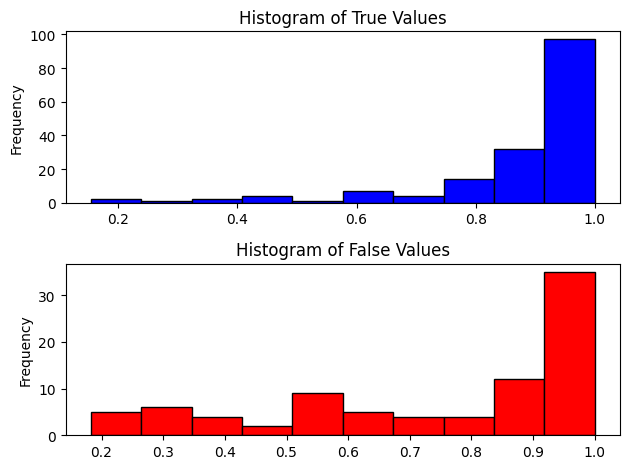

In [32]:
show_confidence()


In [18]:
for dp in all_data:
    for ent in dp['logits_for_tags'] :
        ent = add_confidence_to_results(ent)